# Árboles de decisión

Forma gráfica y analítica que presenta sucesos y sus posibles consecuencias.

**Ventajas**

- Claridad en los datos
- Tolerantes al ruido y valores faltantes
- Las reglas extraídas permiten hacer predicciones

**Desventajas**
- Criterio de división es deficiente
- Sobreajuste
- Ramas pocos significativas

**¿Cómo se divide un árbol de decisión?**
- Ganancia de información
- Dividir en pequeños árboles

**Optimización de nuestro modelo**
- Evitar sobreajuste
- Selección de atributos
- Campos nulos


_____________________________________

## Librerías

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fundamentos_ML.utils.paths as path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set()

## Leyendo datos

Debido a la complejidad del dataset, se emplearon dos archivos con los datos ya dividos

In [3]:
input_train_data = path.data_raw_dir('titanic-train.csv')
df_train = pd.read_csv(input_train_data)
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
input_test_data = path.data_raw_dir('titanic-test.csv')
df_test = pd.read_csv(input_test_data)
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Exploración de datos (pasajeros sobrevivientes)

A continuación, se muestra la gráfica de distribución de pasajero en el Titanic. Como vemos, el barco contaba con más hombres que mujeres.

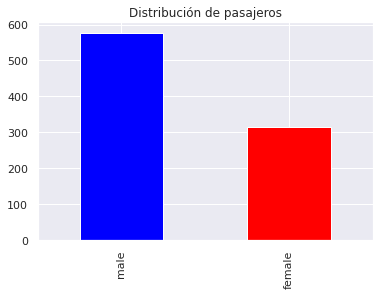

In [6]:
df_train.Sex.value_counts().plot(kind='bar', color=['blue','red'])
plt.title('Distribución de pasajeros')
plt.show()

Ahora, veamos la distribución de los pasajeros sobrevivientes para hombres y mujeres. Para esto, utilizaremos la librería Seaborn

In [7]:
# Count of the passenger survived by sex
df_train_count = df_train.groupby(['Sex','Survived'])[['PassengerId']].count()
df_train_count


PassengerId
Sex    Survived             
female 0                  81
       1                 233
male   0                 468
       1                 109

In [8]:
# Calculatiing the percentage
df_train_count['Survived (%)']= df_train_count.groupby(level=0).apply(lambda x: x / x.sum() * 100)
df_train_count

PassengerId  Survived (%)
Sex    Survived                           
female 0                  81     25.796178
       1                 233     74.203822
male   0                 468     81.109185
       1                 109     18.890815

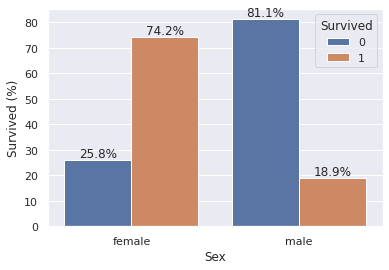

In [9]:
# Plotting with seaborn
ax = sns.barplot(x='Sex', y='Survived (%)', hue='Survived', data=df_train_count.reset_index())

for container in ax.containers:
    ax.bar_label(container, fmt='%.01f%%')

## Procesando datos

### Creando un clasificador con Scikit-Learn

In [10]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

encoder_sex = label_encoder.fit_transform(df_train['Sex'])
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Es habitual tener que manejar y limpiar los valores nulos, ya que los modelos de árboles de decisión son muy afectados por los datos faltantes

In [11]:
# Lets check if there are columns with null values
df_train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [12]:
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())
df_train['Embarked'] = df_train['Embarked'].fillna('S')

Eliminamos las columnas que no son de interés para nuestro modelo de árbol de decisión.

In [13]:
train_predictors = df_train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

categorical_cols = [cname for  cname in train_predictors.columns if
    train_predictors[cname].nunique() < 10 and 
    train_predictors[cname].dtype == 'object'
    ]
categorical_cols

['Sex', 'Embarked']

In [14]:
numerical_cols = [cname for cname in train_predictors.columns if 
    train_predictors[cname].dtype in ['int64', 'float64']
    ]
numerical_cols

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [15]:
my_cols = categorical_cols + numerical_cols

train_predictors = train_predictors[my_cols]
train_predictors

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,male,S,3,22.0,1,0,7.2500
1,female,C,1,38.0,1,0,71.2833
2,female,S,3,26.0,0,0,7.9250
3,female,S,1,35.0,1,0,53.1000
4,male,S,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,male,S,2,27.0,0,0,13.0000
887,female,S,1,19.0,0,0,30.0000
888,female,S,3,28.0,1,2,23.4500
889,male,C,1,26.0,0,0,30.0000


Por último, realizamos una conversión de variables categóricas a variables numéricas

In [16]:
dummy_encoded_train_predictor = pd.get_dummies(train_predictors)
dummy_encoded_train_predictor

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,19.0,0,0,30.0000,1,0,0,0,1
888,3,28.0,1,2,23.4500,1,0,0,0,1
889,1,26.0,0,0,30.0000,0,1,1,0,0


In [17]:
df_train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [18]:
output_titanic_file = path.data_processed_dir("titanic-train-processed.csv")
dummy_encoded_train_predictor.to_csv(output_titanic_file, index=False)

## Entrenamiento del modelo

In [19]:
# Read data
input_processed_data = path.data_processed_dir('titanic-train-processed.csv')
df_processed = pd.read_csv(input_processed_data)
df_processed.head(5)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Dividimos primero nuestros datos

In [20]:
y_target = df_train['Survived'].values
x_features_one = df_processed.values

In [21]:
X_train, X_validation, y_train, y_validation = train_test_split(x_features_one, y_target, test_size=0.25, random_state=1)

Creamos nuestro modelo y lo ajustamos

In [22]:
tree_one = tree.DecisionTreeClassifier()
tree_one = tree_one.fit(X_train, y_train)

Validamos nuestro modelo

In [23]:
tree_one_accuracy = round(tree_one.score(X_validation, y_validation), 4)
print(f"Accuracy: {tree_one_accuracy}")

Accuracy: 0.7399
